In [1]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
#model

import torch 
import torch.nn as nn


class ScratchNet(nn.Module):
    def __init__(self):
        super(ScratchNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10, bias=False)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x
        
model = ScratchNet()


In [4]:
print(X_train[0:10].shape)
a  = X_train[0:10].reshape(-1, 28*28)
print(a.shape)

(10, 28, 28)
(10, 784)


In [5]:
model(torch.Tensor(X_train[0:10]).reshape(-1, 28*28))

tensor([[ 11.0974,  -3.4006,  22.6927,  -5.1369,  27.3621, -23.2192,   3.8462,
          13.0286, -16.7455, -39.1692],
        [ 26.0397,  26.6760,  17.7316,   1.7417,  38.8928, -28.9960, -22.8341,
           8.2458,  -4.7510, -20.6826],
        [  7.0904,  26.0841,  17.3570,  12.8837,  38.7696, -18.7537, -15.5012,
          14.0444,   3.8829, -23.5329],
        [ 10.8549,   6.5598,  20.2274, -13.3710,  -1.7586, -27.3057, -23.9947,
          -9.3685,   1.9375, -32.2624],
        [  7.5936,  12.2028,  37.6561, -12.0115,  24.9797, -10.2103, -38.5721,
          -0.1587, -23.2854, -46.9485],
        [  1.4871,  10.3490,  -5.6309,  -2.0617,  44.1153, -26.4623,  -8.5208,
         -10.4469, -22.3628, -34.6993],
        [ -9.3243,  -9.9268,  24.7773,   0.3062,  30.2043, -20.0442,  -0.0964,
           1.8198,  -1.0527, -27.0657],
        [ -1.7846,   0.5598,  32.6572, -16.4307,  48.8783, -25.0273,  -8.5570,
          21.7623, -13.5151, -34.7773],
        [  0.8163, -11.9055,  16.0728,  -5.1106,

In [6]:
len(Y_train[0:100])

100

loss 46.13 accuracy 0.18:   0%|          | 0/1000 [00:00<?, ?it/s]

loss 0.23 accuracy 0.94: 100%|██████████| 1000/1000 [00:03<00:00, 287.31it/s]


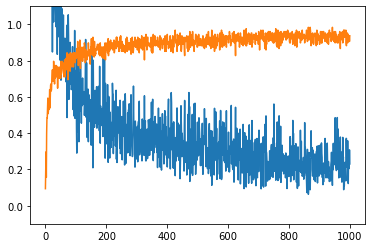

In [7]:
#training

loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001)
BATCH_SIZE = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad()
  out = model(X)
  accc = torch.argmax(out, dim=1)
  accuracy = (accc == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [8]:
#Evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9275

In [9]:
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
l1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
#let's print the dtypes of all 
print(type(model))
print(type(model.l1))
print(type(model.l1.weight))
print(type(model.l1.weight[0]))


<class '__main__.ScratchNet'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'>


In [11]:
# Why Detach?: Sometimes, you might want to perform some operations on a tensor without having these operations tracked in the computation graph.

l1[:] = model.l1.weight.detach().numpy().transpose()
l2[:] = model.l2.weight.detach().numpy().transpose()


In [12]:
X_test.reshape((-1, 28*28)).shape


(10000, 784)

In [14]:
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x


forward(X_test.reshape((-1, 28*28))).shape


(10000, 10)

In [24]:
Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(forward(X_test.reshape((-1, 28*28))), axis=1)
Y_test_preds

array([7, 2, 1, ..., 4, 5, 6])

In [23]:
(Y_test == Y_test_preds).mean()

0.9275

In [34]:
#Lets do the training in numpy

np.log(np.exp(Y_test_preds_out)).sum(axis=1)

array([ -9.799355  ,  -0.32608128, -23.27645   , ...,  -7.67814   ,
       -43.84518   ,   9.204264  ], dtype=float32)

In [45]:
#cross entropy loss formual--> log part 

np.log(np.exp(Y_test_preds_out[0]).sum())

12.57369

In [54]:
#for all the 10000 examples calculating the loss

Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] 

array([12.573588 , 13.686531 ,  6.923329 , ..., 10.257198 ,  6.9869366,
       15.226138 ], dtype=float32)

In [57]:
#full loss formula and calculating for all the 10K examples

CE = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + \
    np.log(np.exp(Y_test_preds_out[0]).sum())


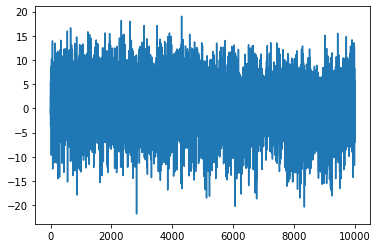

In [58]:
plot(CE)